In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
import re
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [39]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [40]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [41]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating"]].rename(columns={"Book Id":"book_id", "My Rating":"rating"}).query("rating > 0")

# Reformat to fit sparse matrix
my_books = pd.merge(book_index, my_books, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# # Replace 0 with 0.1 to prevent cosine similarities from zeroing
# sparse_fill = 0.001
# df_reviews.data[df_reviews.data == 0] = sparse_fill

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

### 1.1 - User:User Collaborative Filtering with KNN

In [42]:
target = df_reviews.shape[0] - 1

In [43]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(columns={0:"uid",1:"book_index",2:"user_rating"})

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(ind_books.reset_index(), neighbor_user_ratings, how="inner", left_on="index", right_on="book_index")
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame([target_user_books, target_user_book_rat]).T.rename(columns={0:"book_index",1:"user_rating"})
    target_user_ratings = pd.merge(ind_books.reset_index(), target_user_ratings, how="inner", left_on="index", right_on="book_index")
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [44]:
n_neighbors = 75
neighbor_user_ratings, target_user_ratings = find_neighbors(n_neighbors, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_3762/1706490840.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_3762/1706490840.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [45]:
# View neighbors rating table
neighbor_user_ratings.head()

,book_id,uid,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25
0,100915,83359.0,5497.0,0.267860,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,2005,eng,https://images.gr-assets.com/books/1353029077m...,...,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298
1,10127019,149314.0,8108.0,0.114992,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,2011,en-US,https://images.gr-assets.com/books/1333576876m...,...,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015
2,10193060,122168.0,13183.0,0.248452,Miserere: An Autumn Tale,3.79,747.0,2011,eng,https://images.gr-assets.com/books/1301084223m...,...,0.006133,0.006133,0.006133,0.006133,0.006133,0.006133,0.852806,0.006133,0.006133,0.006133
3,10245518,133863.0,17082.0,0.158986,The Checklist Manifesto How to Get Things Right,4.03,268.0,2011,eng,https://images.gr-assets.com/books/1356488549m...,...,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696
4,10321016,204297.0,22603.0,0.368230,Pitch Anything: An Innovative Method for Prese...,4.09,4346.0,2011,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,...,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604


### 1.2 - Generate Recommendations from Similar Readers

In [46]:
# 20 most popular books among similar readers
popular_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
    .nlargest(20, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)

popular_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
215,The Gunslinger,3.98,346978.0,1982,5.3%
177,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,1997,4.0%
125,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,4.0%
98,Judas Unchained,4.30,21306.0,2005,2.7%
13,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,2.7%
286,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.7%
210,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,2.7%
76,"Gateway (Heechee Saga, #1)",4.07,30282.0,2004,2.7%
149,"Ringworld (Ringworld, #1)",3.96,78483.0,2005,2.7%
220,The Hike,3.92,5603.0,2016,2.7%


In [47]:
# 10 highest rated books among similar readers
highest_rated_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
    .nlargest(20, "avg_rating").rename(columns={"book_id":"percent_similar_users_read"})

highest_rated_recs["percent_similar_users_read"] = (highest_rated_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)
highest_rated_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
251,The Story of Human Language,4.44,394.0,2004,1.3%
260,"The Walking Dead, Compendium 1",4.43,58434.0,2009,1.3%
101,"Kings of the Wyld (The Band, #1)",4.42,2285.0,2017,1.3%
10,Adventure Time With Fionna and Cake,4.41,2542.0,2013,1.3%
53,David Attenborough's Life on Air: Memoirs of a...,4.39,1836.0,2003,1.3%
231,The Looming Tower: Al-Qaeda and the Road to 9/11,4.38,13019.0,2006,1.3%
83,Homicide: A Year on the Killing Streets,4.37,10487.0,1991,1.3%
155,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0,2013,1.3%
191,The Complete Works of H.P. Lovecraft,4.34,9733.0,2011,1.3%
256,The Tower of Swallows,4.33,288.0,2016,1.3%


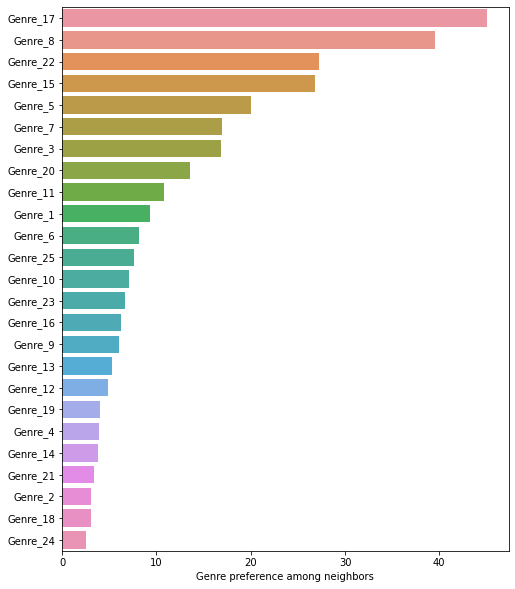

In [48]:
# Plot target reader's top genres
fig, ax = plt.subplots(figsize=(8,10))
genre_ranking = pd.DataFrame(neighbor_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0
)
plt.xlabel("Genre preference among neighbors")
plt.show()

In [49]:
# Loop through genres in descending relevance order and print top recs
for genre in genre_ranking.index[0:5]:
    
    g = float(genre[6:])
    highest_rated_recs_genre = neighbor_user_ratings.query("main_genre == @g")\
        .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .rename(columns={"book_id":"percent_similar_users_read"})

    highest_rated_recs_genre["percent_similar_users_read"] = highest_rated_recs_genre["percent_similar_users_read"] / n_neighbors
    highest_rated_recs_genre = highest_rated_recs_genre.query("ratings_count > 400 & avg_rating > 3.9")

    # Print genre name and descriptor
    for nt in genre_descriptors.itertuples():
        genre_rep = genre.replace("_"," ")
        if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
            print(nt.genre_string)
            
    display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(10))
    print("_____\n")

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
48,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
16,"Kings of the Wyld (The Band, #1)",4.42,2285.0,https://www.goodreads.com/book/show/30841984-k...
15,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
18,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
24,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...
40,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...
46,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,703.0,https://www.goodreads.com/book/show/27213244-t...
34,Star Wars #1,4.17,1109.0,https://www.goodreads.com/book/show/24496462-s...
17,"Live Free or Die (Troy Rising, #1)",4.16,6544.0,https://www.goodreads.com/book/show/6713634-li...
23,Outland,4.14,786.0,https://www.goodreads.com/book/show/24292598-o...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
6,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
11,"Don't Make Me Think, Revisited: A Common Sense...",4.24,4444.0,https://www.goodreads.com/book/show/18197267-d...
12,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0,https://www.goodreads.com/book/show/9963483-fa...
2,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0,https://www.goodreads.com/book/show/25894085-b...
10,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0,https://www.goodreads.com/book/show/5944774-de...
4,"Boundaries: When to Say Yes, How to Say No to ...",4.19,13041.0,https://www.goodreads.com/book/show/944267.Bou...
9,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
1,"After the Ecstasy, the Laundry: How the Heart ...",4.16,3187.0,https://www.goodreads.com/book/show/341631.Aft...
37,"The Vital Question: Energy, Evolution, and the...",4.14,843.0,https://www.goodreads.com/book/show/23316494-t...
23,Superforecasting: The Art and Science of Predi...,4.13,4876.0,https://www.goodreads.com/book/show/23995360-s...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
12,Michael Moorcock's Elric of Melnibone,4.32,1137.0,https://www.goodreads.com/book/show/8658529-mi...
28,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0,https://www.goodreads.com/book/show/31140332-t...
0,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,https://www.goodreads.com/book/show/26863057-a...
9,"Lion of Macedon (Greek Series, #1)",4.24,3375.0,https://www.goodreads.com/book/show/257054.Lio...
20,The False Prince (The Ascendance Trilogy #1),4.23,51292.0,https://www.goodreads.com/book/show/12432220-t...
11,Lost Boy: The True Story of Captain Hook,4.20,1420.0,https://www.goodreads.com/book/show/32828538-l...
14,Nine Princes in Amber (The Chronicles of Amber...,4.10,38729.0,https://www.goodreads.com/book/show/92121.Nine...
4,Darth Plagueis,4.08,9273.0,https://www.goodreads.com/book/show/11099729-d...
16,Prelude to Foundation,4.05,41694.0,https://www.goodreads.com/book/show/30013.Prel...
6,Down Town (The Dresden Files Graphic Novels),4.02,651.0,https://www.goodreads.com/book/show/25558821-d...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
16,The Circular Ruins,4.30,409.0,https://www.goodreads.com/book/show/28110198-t...
11,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
26,The World of Ice & Fire: The Untold History of...,4.26,12952.0,https://www.goodreads.com/book/show/17345242-t...
0,Atlas of Remote Islands,4.24,1807.0,https://www.goodreads.com/book/show/8197735-at...
17,The Hero With a Thousand Faces,4.24,18378.0,https://www.goodreads.com/book/show/588138.The...
24,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0,https://www.goodreads.com/book/show/26887738-t...
13,The 50th Law,4.13,4254.0,https://www.goodreads.com/book/show/6043946-th...
20,The Story of B: An Adventure of the Mind and S...,4.11,7822.0,https://www.goodreads.com/book/show/214579.The...
27,Thousandth Night,4.10,434.0,https://www.goodreads.com/book/show/18129561-t...
19,The Rest Is Noise: Listening to the Twentieth ...,4.08,9607.0,https://www.goodreads.com/book/show/392563.The...


_____

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
11,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
9,"Killer of Men (Long War, #1)",4.27,1176.0,https://www.goodreads.com/book/show/7998933-ki...
10,Man-Eaters of Kumaon,4.25,2609.0,https://www.goodreads.com/book/show/475245.Man...
3,An Era of Darkness: The British Empire in India,4.23,875.0,https://www.goodreads.com/book/show/32618967-a...
19,"Working Stiff: Two Years, 262 Bodies, and the ...",4.11,8101.0,https://www.goodreads.com/book/show/18775327-w...
5,Dawn (Legend of the Galactic Heroes #1),4.06,418.0,https://www.goodreads.com/book/show/25986983-dawn
8,If the Oceans Were Ink: An Unlikely Friendship...,4.02,792.0,https://www.goodreads.com/book/show/22320455-i...
12,Pastwatch: The Redemption of Christopher Columbus,3.96,12053.0,https://www.goodreads.com/book/show/40293.Past...
13,"Reckless Endangerment: How Outsized Ambition, ...",3.93,1121.0,https://www.goodreads.com/book/show/10855141-r...


_____



### 2.1 - User:Item Collaborative Filtering with Matrix Factorization

In [50]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
large_neighborhood_ratings, target_user_ratings = find_neighbors(1000, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_3762/1706490840.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_3762/1706490840.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [51]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [68]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k = 10)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

### 2.2 - Generating Recommendations by Making Rating Predictions from Matrix Factorization

In [69]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index).reset_index()

In [70]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]], on="book_id")\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
top_preds.drop(["book_index"], axis=1, inplace=True)
top_preds.head(10)

,predicted_rating,title,avg_rating,ratings_count,year,main_genre,url
6,0.030598,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,2003,8.0,https://www.goodreads.com/book/show/10235.Moun...
9,0.025237,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,2014,8.0,https://www.goodreads.com/book/show/18077903-c...
10,0.025200,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,2006,8.0,https://www.goodreads.com/book/show/1202.Freak...
11,0.024873,Dirt: The Erosion of Civilizations,3.94,736.0,2007,5.0,https://www.goodreads.com/book/show/587916.Dirt
12,0.024149,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,2006,5.0,https://www.goodreads.com/book/show/4373.First...
13,0.022368,I Have Lived a Thousand Years,4.16,16409.0,1999,20.0,https://www.goodreads.com/book/show/48834.I_Ha...
14,0.015217,Pandora's Star,4.24,28964.0,2005,17.0,https://www.goodreads.com/book/show/45252.Pand...
15,0.014293,Black Holes and Baby Universes,4.09,9704.0,1994,15.0,https://www.goodreads.com/book/show/53200.Blac...
16,0.014283,A Death in Italy: The Definitive Account of th...,3.71,284.0,2009,9.0,https://www.goodreads.com/book/show/13539495-a...
17,0.014143,Judas Unchained,4.30,21306.0,2005,17.0,https://www.goodreads.com/book/show/45244.Juda...


In [75]:
# Loop through genres in descending relevance order and print top recs
for genre in genre_ranking.index[0:10]:
    
    g = float(genre[6:])
    highest_rated_pred_genre = top_preds.query("main_genre == @g")\
        .sort_values(by="predicted_rating", ascending=False)\
        .query("ratings_count > 400 & avg_rating >= 4.0")\

    # Print genre name and descriptor
    for nt in genre_descriptors.itertuples():
        genre_rep = genre.replace("_"," ")
        if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
            print(nt.genre_string)
    
    display(highest_rated_pred_genre[["title", "avg_rating", "ratings_count","url"]].iloc[0:20,:])
    print("_____\n")

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
14,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...
17,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
23,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
109,The Demon in the Freezer,4.10,8213.0,https://www.goodreads.com/book/show/198505.The...
202,"Live Free or Die (Troy Rising, #1)",4.16,6544.0,https://www.goodreads.com/book/show/6713634-li...
229,The Humanure Handbook: A Guide to Composting H...,4.36,709.0,https://www.goodreads.com/book/show/989670.The...
231,The Dispossessed: An Ambiguous Utopia (Hainish...,4.18,1071.0,https://www.goodreads.com/book/show/6602919-th...
309,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...
322,The Evolutionary Void,4.26,13729.0,https://www.goodreads.com/book/show/7438179-th...
361,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
6,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
9,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
18,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
65,Doing Good Better: How Effective Altruism Can ...,4.23,1265.0,https://www.goodreads.com/book/show/23398748-d...
124,Continuous Delivery: Reliable Software Release...,4.15,1748.0,https://www.goodreads.com/book/show/8686650-co...
133,The Miracle of Mindfulness: An Introduction to...,4.26,13653.0,https://www.goodreads.com/book/show/95747.The_...
134,Happiness: A Guide to Developing Life's Most I...,4.14,2999.0,https://www.goodreads.com/book/show/96885.Happ...
137,The Art of Living: Vipassana Meditation: As Ta...,4.30,1098.0,https://www.goodreads.com/book/show/384312.The...
138,The Great Cholesterol Myth: Why Lowering Your ...,4.29,804.0,https://www.goodreads.com/book/show/13590581-t...
157,Superforecasting: The Art and Science of Predi...,4.13,4876.0,https://www.goodreads.com/book/show/23995360-s...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
186,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,https://www.goodreads.com/book/show/43841.When...
298,Rogue One: A Star Wars Story,4.17,3228.0,https://www.goodreads.com/book/show/30008713-r...
355,"The Last Namsara (Iskari, #1)",4.25,865.0,https://www.goodreads.com/book/show/32667458-t...
384,The Cartel,4.29,9961.0,https://www.goodreads.com/book/show/23602561-t...
659,"Red Sister (Book of the Ancestor, #1)",4.32,5784.0,https://www.goodreads.com/book/show/25895524-r...
668,Death Note Box Set,4.54,2456.0,https://www.goodreads.com/book/show/3368983-de...
722,"Wonder Woman, Volume 6: Bones",4.14,1730.0,https://www.goodreads.com/book/show/23012564-w...
784,"Stories of the Raksura, Volume 1: The Falling ...",4.27,535.0,https://www.goodreads.com/book/show/20344635-s...
840,Lost Boy: The True Story of Captain Hook,4.20,1420.0,https://www.goodreads.com/book/show/32828538-l...
844,"Asterix the Gaul (Asterix, #1)",4.16,17151.0,https://www.goodreads.com/book/show/71292.Aste...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
43,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
85,Cosmicomics,4.20,10568.0,https://www.goodreads.com/book/show/59780.Cosm...
103,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
127,"The Big Picture: On the Origins of Life, Meani...",4.18,2208.0,https://www.goodreads.com/book/show/26150770-t...
165,The Laugh of the Medusa,4.16,752.0,https://www.goodreads.com/book/show/11080013-t...
220,"Short Stories from Hogwarts of Heroism, Hardsh...",4.23,16961.0,https://www.goodreads.com/book/show/31538635-s...
286,Economics in One Lesson: The Shortest & Surest...,4.22,9336.0,https://www.goodreads.com/book/show/3028.Econo...
316,Sixth of the Dusk,4.21,8122.0,https://www.goodreads.com/book/show/23397921-s...
336,"Faraday, Maxwell, and the Electromagnetic Fiel...",4.24,431.0,https://www.goodreads.com/book/show/18240286-f...
390,Srikanta,4.23,1004.0,https://www.goodreads.com/book/show/1417962.Sr...


_____

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
12,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...
22,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
112,"I, Claudius (Claudius, #1)",4.27,39272.0,https://www.goodreads.com/book/show/18765.I_Cl...
156,Digital Gold: Bitcoin and the Inside Story of ...,4.16,1674.0,https://www.goodreads.com/book/show/23546676-d...
199,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
207,"The Prize: The Epic Quest for Oil, Money, and ...",4.40,5329.0,https://www.goodreads.com/book/show/169354.The...
210,Slouching Towards Bethlehem,4.23,18540.0,https://www.goodreads.com/book/show/424.Slouch...
211,"Lawrence in Arabia: War, Deceit, Imperial Foll...",4.12,7839.0,https://www.goodreads.com/book/show/17262206-l...
242,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
250,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...


_____

Genre 7: ['fairy', 'magic', 'adventure', 'world', 'magical', 'die', 'fantasy', 'journey', 'young', 'land']


,title,avg_rating,ratings_count,url
315,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0,https://www.goodreads.com/book/show/15177.Brid...
375,"Toby Alone (Tobie Lolness, #1)",4.18,1467.0,https://www.goodreads.com/book/show/2535732.To...
652,Jaya: An Illustrated Retelling of the Mahabharata,4.20,9857.0,https://www.goodreads.com/book/show/9864913-jaya
924,"The 13½ Lives of Captain Bluebear (Zamonia, #1)",4.20,10790.0,https://www.goodreads.com/book/show/62032.The_...
1003,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,https://www.goodreads.com/book/show/100915.The...
1152,"The Summer Queen (Eleanor of Aquitaine, #1)",4.10,2935.0,https://www.goodreads.com/book/show/16125281-t...
1202,The Wind Through the Keyhole,4.15,37166.0,https://www.goodreads.com/book/show/12341557-t...
1268,Homeland (Forgotten Realms: The Dark Elf Trilo...,4.27,50532.0,https://www.goodreads.com/book/show/50027.Home...
1488,The Sandman: The Dream Hunters,4.46,8365.0,https://www.goodreads.com/book/show/6307034-th...
1516,Instructions,4.29,4598.0,https://www.goodreads.com/book/show/7023148-in...


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
76,Y: The Last Man - The Deluxe Edition Book One,4.36,10549.0,https://www.goodreads.com/book/show/3710603-y
142,The Kite Runner: Graphic Novel,4.25,6466.0,https://www.goodreads.com/book/show/11296523-t...
217,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
430,The Private Eye,4.24,1847.0,https://www.goodreads.com/book/show/26247784-t...
691,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
716,"Batman: Earth One, Volume 2",4.22,2332.0,https://www.goodreads.com/book/show/23012543-b...
808,His Last Bow: 8 Stories,4.28,21597.0,https://www.goodreads.com/book/show/754713.His...
839,Adventure Time With Fionna and Cake,4.41,2542.0,https://www.goodreads.com/book/show/17348705-a...
854,Robot Visions (Robot #0.5),4.20,6504.0,https://www.goodreads.com/book/show/41823.Robo...
875,"Batman, Volume 3: Death of the Family",4.33,8461.0,https://www.goodreads.com/book/show/17671913-b...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
13,I Have Lived a Thousand Years,4.16,16409.0,https://www.goodreads.com/book/show/48834.I_Ha...
19,Night (The Night Trilogy #1),4.30,708754.0,https://www.goodreads.com/book/show/1617.Night
39,Daytripper,4.31,18265.0,https://www.goodreads.com/book/show/8477057-da...
78,My Journey : Transforming Dreams into Actions,4.35,1743.0,https://www.goodreads.com/book/show/18371021-m...
93,Evicted: Poverty and Profit in the American City,4.47,18205.0,https://www.goodreads.com/book/show/25852784-e...
118,The Woman on the Orient Express,4.15,2305.0,https://www.goodreads.com/book/show/29806077-t...
173,Stag's Leap: Poems,4.10,1975.0,https://www.goodreads.com/book/show/13330670-s...
184,Those Who Save Us,4.12,4984.0,https://www.goodreads.com/book/show/10316205-t...
353,Hum If You Don’t Know the Words,4.22,971.0,https://www.goodreads.com/book/show/28264701-h...
419,You Don't Have to Say You Love Me,4.36,4478.0,https://www.goodreads.com/book/show/31420708-y...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
90,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
374,Shooting an Elephant,4.11,5920.0,https://www.goodreads.com/book/show/30557.Shoo...
542,The Refrigerator Monologues,4.21,894.0,https://www.goodreads.com/book/show/32714267-t...
754,Animal Farm / 1984,4.26,120269.0,https://www.goodreads.com/book/show/5472.Anima...
1069,In the Garden of the North American Martyrs,4.15,1706.0,https://www.goodreads.com/book/show/54510.In_t...
1450,The Dot and the Line: A Romance in Lower Mathe...,4.35,1197.0,https://www.goodreads.com/book/show/289866.The...
1710,Our Story Begins: New and Selected Stories,4.13,1670.0,https://www.goodreads.com/book/show/1753685.Ou...
1852,The Thing on the Doorstep,4.11,1261.0,https://www.goodreads.com/book/show/6555373-th...
2168,Heart of a Dog,4.14,20661.0,https://www.goodreads.com/book/show/113205.Hea...
2536,Bigfoot: I Not Dead,4.20,1054.0,https://www.goodreads.com/book/show/2272713.Bi...


_____

Genre 1: ['family', 'young', 'house', 'home', 'island', 'village', 'secret', 'world', 'old', 'beautiful']


,title,avg_rating,ratings_count,url
140,Beyond the Sky and the Earth: A Journey into B...,4.13,2641.0,https://www.goodreads.com/book/show/145249.Bey...
258,"Come, Tell Me How You Live",4.16,1735.0,https://www.goodreads.com/book/show/111516.Com...
392,The Bear and the Nightingale (The Winternight ...,4.14,14404.0,https://www.goodreads.com/book/show/25489134-t...
537,The Plover,4.18,1010.0,https://www.goodreads.com/book/show/17934485-t...
938,From the Holy Mountain: A Journey Among the Ch...,4.28,2038.0,https://www.goodreads.com/book/show/104039.Fro...
1004,"Dreams Underfoot (Newford, #1)",4.11,6978.0,https://www.goodreads.com/book/show/186444.Dre...
1055,"My Family and Other Animals (Corfu Trilogy, #1)",4.26,20655.0,https://www.goodreads.com/book/show/48132.My_F...
1149,"Dragonsong (Harper Hall, #1)",4.24,36174.0,https://www.goodreads.com/book/show/28541.Drag...
1315,A Trail of Fire,4.24,2001.0,https://www.goodreads.com/book/show/13629443-a...
1665,Out of Africa / Shadows on the Grass,4.25,8242.0,https://www.goodreads.com/book/show/26474.Out_...


_____

